# Jaws Segmentation Dataset

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal.

In [1]:
# ! pip install --user torch torchvision matplotlib numpy progressbar

In [2]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms

In [3]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [4]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip


100% |########################################################################|


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip


100% |########################################################################|


## Explore The Dataset

In [7]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [8]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])

In [9]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')

axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
coronal training dataset: 7277 slice
sagittal training dataset: 7277 slice


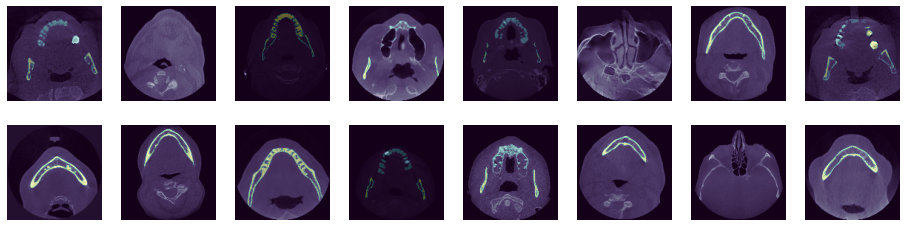

In [10]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

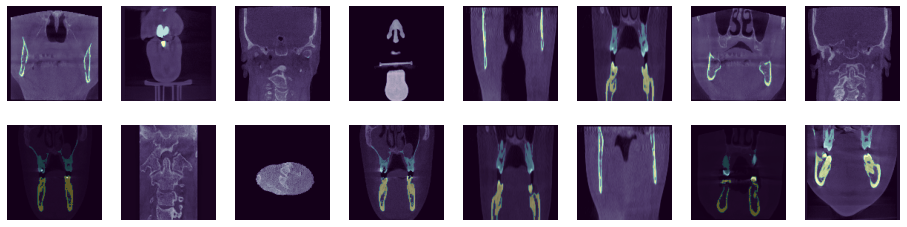

In [11]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

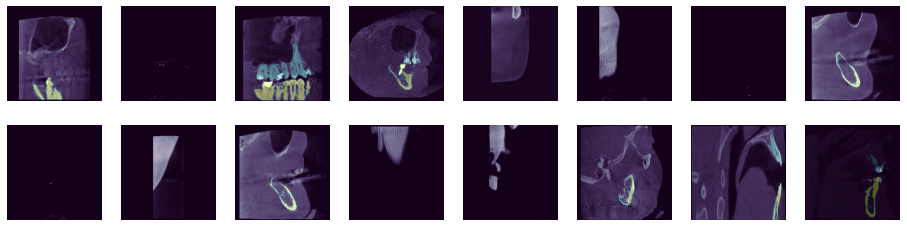

In [12]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)